In [1]:
import os
import sys
import io
import numpy as np
import math
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

data_dir = os.path.join(os.getcwd(), "data")
models_dir = os.path.join(os.getcwd(), "models")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics

Using TensorFlow backend.
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pawel/.local/lib/python3.7/site-packages/tensorflow/python/fra

In [3]:
from multiprocessing import Process, Pool
from queue import Queue
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from imageio import imread
            
results = Queue()

class ImgProcessor:   
    global X
    global y
    
    def __call__(self, file_path):        
        try:
            im = imread(file_path, pilmode="L")
            return im, os.path.basename(os.path.dirname(file_path))
        except Exception as e:
            print(e)
            print(file_path)
            
t0 = time.time()
not_minst_dir = os.path.join(data_dir, "notMNIST_large")
        
print("Listing files, categories: ", end=', ')
paths = list()
for root, _, files in os.walk(not_minst_dir):
    if not files:
        continue;
    letter = os.path.basename(root)
    print(letter, end=', ')
    for name in files:
        img_path = os.path.join(root, name)
        paths.append(img_path)

print("Images count: {}".format(len(paths)))

proc=ImgProcessor()
pool=Pool()
rs = pool.map_async(proc, paths, callback=results.put)
pool.close()

while (True):
  if rs.ready(): 
    break
  remaining = rs._number_left
  print("Waiting for", remaining, "tasks to complete...", end="\r")
  time.sleep(1)

X = list()
y = list()

img_size = len(results.queue[0][0][0])
img_flattened_size = img_size * img_size
intermediate_size = 256

data = [r for r in results.queue[0] if r]
count = len(data)
print(F"Image sie: {img_size}, Count:{count}")

for num, (_x, _y) in enumerate(data):
    if not num%1000:
        print(F"Processing data: {num}/{count}", end="\r")
    _x = _x.reshape([img_flattened_size])
    X.append(_x/255.0)
    y.append(_y)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

tf = time.time() - t0
print(F"Finished. processing time:{tf}s.")

Listing files, categories: , E, G, J, D, C, B, F, H, I, A, Images count: 529119
_open() got an unexpected keyword argument 'pilmode'
/home/pawel/git/3dml/5_generative_networks/data/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png
_open() got an unexpected keyword argument 'pilmode'
/home/pawel/git/3dml/5_generative_networks/data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
_open() got an unexpected keyword argument 'pilmode'
/home/pawel/git/3dml/5_generative_networks/data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png
_open() got an unexpected keyword argument 'pilmode'
/home/pawel/git/3dml/5_generative_networks/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
_open() got an unexpected keyword argument 'pilmode'
/home/pawel/git/3dml/5_generative_networks/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Image sie: 28, Count:529114lete...
Finished. processing time:21.697003841400146s.


len(X):  529114
y:  E
X:


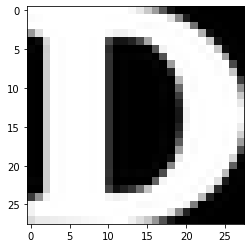

In [4]:
# Show data:
print("len(X): ", len(X))
print("y: ", y[32])
print("X:")
plt.imshow(X_train[32].reshape(28, 28), cmap=plt.get_cmap('gray'))

In [5]:
intermediate_dim = 256
latent_dim= 2

input_layer= Input(shape=(img_flattened_size,))
intermediate_layer= Dense(intermediate_dim, activation='relu', name='intermediate_layer')(input_layer)
z_mean=Dense(latent_dim, name='z-mean')(intermediate_layer)
z_log_var=Dense(latent_dim, name='z_log_var')(intermediate_layer)

encoder_module = Model(input_layer, (z_mean, z_log_var))
encoder_module.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_layer (Dense)      (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
z-mean (Dense)                  (None, 2)            514         intermediate_layer[0][0]         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         intermediate_layer[0][0]         
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
____________________

In [6]:
epsilon_std = 1
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var/2.0)*epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
#Decoder module
decoder_h= Dense(intermediate_dim, activation='relu')
decoder_mean= Dense(img_flattened_size, activation='sigmoid')
h_decoded=decoder_h(z)
x_decoded_mean=decoder_mean(h_decoded)

In [8]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = img_flattened_size * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        return x
y = CustomVariationalLayer()([input_layer, x_decoded_mean])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
vae = Model(input_layer, y)
vae.compile(optimizer='rmsprop', loss=None)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [10]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_layer (Dense)      (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
z-mean (Dense)                  (None, 2)            514         intermediate_layer[0][0]         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         intermediate_layer[0][0]         
____________________________________________________________________________________________

In [11]:
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)
y_train = np.stack(y_train, axis=0)
y_test = np.stack(y_test, axis=0)

In [12]:
vae.fit(X_train, shuffle=True, validation_data=(X_test, None), verbose=True, epochs=25, batch_size=300)


Train on 354506 samples, validate on 174608 samples
Epoch 1/25
354506/354506 [==============================] - 5s 13us/step - loss: 394.4809 - val_loss: 373.2089
Epoch 2/25
354506/354506 [==============================] - 4s 11us/step - loss: 367.3866 - val_loss: 361.8644
Epoch 3/25
354506/354506 [==============================] - 4s 11us/step - loss: 359.2046 - val_loss: 354.2629
Epoch 4/25
354506/354506 [==============================] - 4s 11us/step - loss: 354.0486 - val_loss: 351.5986
Epoch 5/25
354506/354506 [==============================] - 4s 11us/step - loss: 350.5370 - val_loss: 351.8244
Epoch 6/25
354506/354506 [==============================] - 4s 11us/step - loss: 347.9554 - val_loss: 345.8171
Epoch 7/25
354506/354506 [==============================] - 4s 12us/step - loss: 345.8010 - val_loss: 345.5271
Epoch 8/25
354506/354506 [==============================] - 4s 11us/step - loss: 344.0821 - val_loss: 344.3287
Epoch 9/25
354506/354506 [==============================] -

<Figure size 576x576 with 0 Axes>

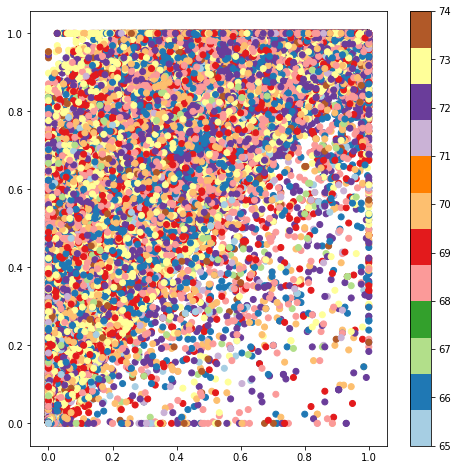

In [13]:
# 2D visualization of latent space
x_test_encoded = vae.predict(X_test, batch_size=300)
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[ord(y) for y in y_test], cmap='Paired')
plt.colorbar()
plt.show()

<Figure size 576x576 with 0 Axes>

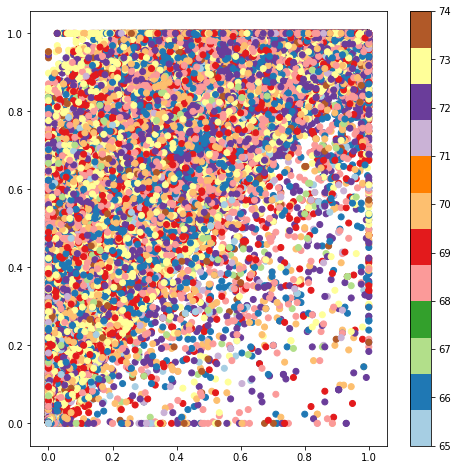

In [14]:
# 2D visualization of latent space
x_test_encoded = vae.predict(X_test, batch_size=256)
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[ord(y) for y in y_test], cmap='Paired')
plt.colorbar()
plt.show()

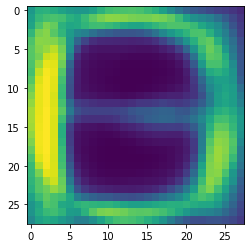

In [15]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

e = generator.predict(np.array([[0.95, 0.9]]))
e = e.reshape((img_size, img_size))
plt.imshow(e)

In [16]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

True

True

In [17]:
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

_x = Input(shape=(img_flattened_size,))
h = Dense(intermediate_dim, activation='relu')(_x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(_x)[0],
                                          latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(img_flattened_size, activation='sigmoid')
])

x_pred = decoder(z)

In [18]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


vae = Model(inputs=[_x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)
#vae.fit(X_train, shuffle=True, validation_data=(X_test, None), verbose=True, epochs=25, batch_size=300)
vae.fit(X_train,
        X_train,
        shuffle=True,
        epochs=25,
        batch_size=300,
        validation_data=(X_test, X_test))

Train on 354506 samples, validate on 174608 samples
Epoch 1/25
354506/354506 [==============================] - 6s 16us/step - loss: 396.9485 - val_loss: 379.2659
Epoch 2/25
354506/354506 [==============================] - 5s 15us/step - loss: 372.7497 - val_loss: 370.3516
Epoch 3/25
354506/354506 [==============================] - 5s 15us/step - loss: 365.5135 - val_loss: 360.5455
Epoch 4/25
354506/354506 [==============================] - 5s 15us/step - loss: 360.4277 - val_loss: 360.3214
Epoch 5/25
354506/354506 [==============================] - 5s 15us/step - loss: 356.8341 - val_loss: 355.3362
Epoch 6/25
354506/354506 [==============================] - 5s 15us/step - loss: 353.9079 - val_loss: 352.6343
Epoch 7/25
354506/354506 [==============================] - 5s 15us/step - loss: 351.1792 - val_loss: 351.6868
Epoch 8/25
354506/354506 [==============================] - 5s 15us/step - loss: 349.0144 - val_loss: 348.7473
Epoch 9/25
354506/354506 [==============================] - 

<Figure size 432x432 with 0 Axes>

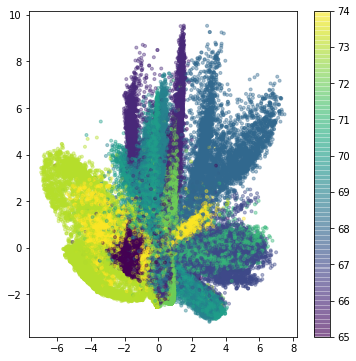

In [19]:
encoder = Model(_x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(X_test, batch_size=300)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=[ord(y) for y in y_test],
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

<Figure size 720x720 with 0 Axes>

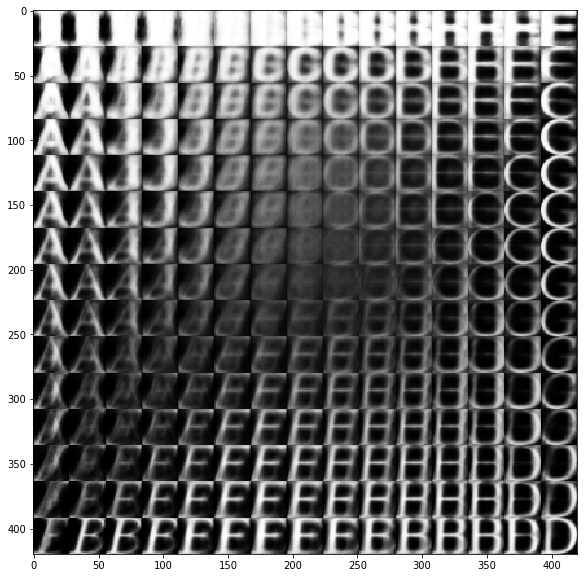

In [20]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

<Figure size 720x720 with 0 Axes>

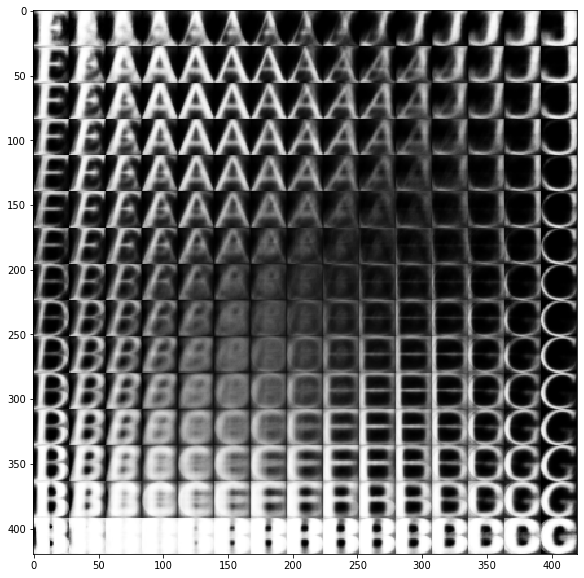

In [21]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = generator.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()